In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [2]:
hci_data=pd.read_csv('HCI_Datasheet.csv')

### Cleaning the data and imputing missing values

I've combined the University and the Programme's name for easier access. Then, I label encoded the categorical columns.
Finally, I filled in the NAN values for the GRE and TOEFL scores with the highest possible scores. I took this approach because students missing those values didn't need them for their decisions; the scores did not affect the process for them.

In [3]:
hci_data=hci_data.drop(columns=['S. No','Decision Date','Application Date'])
hci_data['University_Program']=hci_data.University+' '+hci_data.Programme
hci_data.University=hci_data.University_Program
hci_data=hci_data.drop(columns=['Programme','University_Program','Year of Entry'])

#Label Encoding 

le = preprocessing.LabelEncoder()

hci_data['Decision'] = le.fit_transform(hci_data['Decision']) ### 0-Accepted, 1-Rejected
hci_data['Research Experience'] = le.fit_transform(hci_data['Research Experience']) ###1-Yes, 0-No
hci_data['Submitted Portfolio'] = le.fit_transform(hci_data['Submitted Portfolio']) ###1-Yes, 0-No
hci_data['Student Status'] = le.fit_transform(hci_data['Student Status']) ### 0-Domestic, 1-International, 2-Undergrad domestic

hci_data['GRE']=hci_data['GRE'].fillna(330)
hci_data['TOEFL']=hci_data['TOEFL'].fillna(120)

### I've used CTGAN to synthesize new values based on the current data. Since the Decision is the target variable, I've split the dataset based on that and generated 500 new values each for rejections, and then for acceptances

### For Rejections

In [4]:
rejects_data=hci_data.query('Decision==1')

from ctgan import CTGANSynthesizer
columns=list(rejects_data.columns)
ctgan = CTGANSynthesizer(epochs=100)
ctgan.fit(rejects_data, columns)

In [5]:
synthetic_data_rej = ctgan.sample(500)
synthetic_data_rej.head()

,University,Decision,CGPA,GRE,TOEFL,Work Experience,Research Experience,Research Papers,Submitted Portfolio,Student Status,Class Size,THE Rank,QS Rank
0,Indiana University Bloomington MS HCI/d,1,3.5,325.0,120.0,0.0,1,0,1,1,122,28,152
1,Pratt Institute IXD,1,3.6,330.0,117.0,0.0,0,0,1,2,60,90,72
2,Carnegie Mellon MHCI,1,3.0,330.0,115.0,0.0,0,0,1,1,60,29,72
3,University of Washington MHCID,1,3.7,330.0,108.0,6.0,1,0,1,2,122,90,67
4,Georgia Tech MS HCI,1,3.5,330.0,110.0,1.5,0,0,1,1,122,31,152


#### Comparing with the original dataset

In [6]:
from sdv.evaluation import evaluate
evaluate(synthetic_data_rej, hci_data,metrics=['CSTest', 'LogisticDetection'])

0.7351301405605681

### For Acceptances

In [7]:
accept_data=hci_data.query('Decision==0')

from ctgan import CTGANSynthesizer
columns=list(accept_data.columns)
ctgan = CTGANSynthesizer(epochs=100)
ctgan.fit(accept_data, columns)

In [8]:
synthetic_data_acc = ctgan.sample(500)
synthetic_data_acc.head()

,University,Decision,CGPA,GRE,TOEFL,Work Experience,Research Experience,Research Papers,Submitted Portfolio,Student Status,Class Size,THE Rank,QS Rank
0,University of Texas Austin MSIS,0,3.6,312.0,105.0,3.0,1,0,1,1,50,90,430
1,University of Washington MS HCDE,0,3.8,329.0,113.0,2.0,1,0,1,0,22,29,320
2,University of Maryland (College Park) MS HCI,0,3.3,330.0,120.0,4.0,1,0,1,2,45,38,51
3,Indiana University Purdue MS HCI,0,3.4,330.0,120.0,3.0,0,1,1,1,22,31,72
4,University of Maryland (College Park) MS HCI,0,3.6,330.0,110.0,2.0,0,1,0,0,52,22,430


In [9]:
from sdv.evaluation import evaluate
evaluate(synthetic_data_acc, hci_data,metrics=['CSTest', 'LogisticDetection'])

0.7848982147763538

### Combining Real and Synthetic Data

In [26]:
new_data=pd.concat([hci_data,synthetic_data_acc,synthetic_data_rej],ignore_index=True)
new_data

,University,Decision,CGPA,GRE,TOEFL,Work Experience,Research Experience,Research Papers,Submitted Portfolio,Student Status,Class Size,THE Rank,QS Rank
0,Georgia Tech MS HCI,1,3.8,330.0,117.0,1.0,1,2,1,1,52,38,70
1,Georgia Tech MS HCI,1,3.5,330.0,112.0,4.0,1,6,1,1,52,38,70
2,Georgia Tech MS HCI,1,3.2,330.0,120.0,2.0,1,0,1,0,52,38,70
3,Georgia Tech MS HCI,1,2.7,320.0,113.0,1.5,0,0,1,1,52,38,70
4,Georgia Tech MS HCI,1,3.6,320.0,120.0,1.0,0,0,1,2,52,38,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,University of Washington MHCID,1,3.0,312.0,108.0,6.0,0,2,1,1,52,29,115
1248,University of Washington MS HCDE,1,2.7,330.0,120.0,2.0,1,0,1,0,25,31,760
1249,Carnegie Mellon MHCI,1,3.9,308.0,120.0,0.5,0,6,1,1,35,28,152
1250,Indiana University Bloomington MS HCI/d,1,3.0,325.0,120.0,1.0,0,0,1,1,30,29,72


In [27]:
hci_data.describe()

,Decision,CGPA,GRE,TOEFL,Work Experience,Research Experience,Research Papers,Submitted Portfolio,Student Status,Class Size,THE Rank,QS Rank
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,0.436508,3.501706,323.515873,111.523810,1.658730,0.436508,0.253968,0.793651,0.865079,79.511905,112.242063,160.416667
std,0.496939,0.305213,8.688715,10.784166,1.610042,0.496939,0.718969,0.405489,0.603485,106.563281,165.225865,171.493153
min,0.000000,2.400000,283.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.000000,22.000000,21.000000
25%,0.000000,3.300000,319.000000,106.000000,0.500000,0.000000,0.000000,1.000000,0.000000,35.000000,29.000000,67.000000
50%,0.000000,3.600000,329.000000,114.000000,1.000000,0.000000,0.000000,1.000000,1.000000,50.000000,38.000000,72.000000
75%,1.000000,3.700000,330.000000,120.000000,2.500000,1.000000,0.000000,1.000000,1.000000,60.000000,140.000000,152.000000
max,1.000000,3.980000,335.000000,120.000000,8.000000,1.000000,6.000000,1.000000,2.000000,450.000000,650.000000,760.000000


In [28]:
new_data.describe()

,Decision,CGPA,GRE,TOEFL,Work Experience,Research Experience,Research Papers,Submitted Portfolio,Student Status,Class Size,THE Rank,QS Rank
count,1252.000000,1252.000000,1252.000000,1252.000000,1252.00000,1252.000000,1252.000000,1252.000000,1252.000000,1252.000000,1252.000000,1252.000000
mean,0.487220,3.476174,324.005591,111.039137,1.67492,0.447284,0.273962,0.799521,0.884984,72.064696,124.187700,157.824281
std,0.500036,0.313997,8.785614,10.596105,1.61977,0.497412,0.685018,0.400519,0.588620,92.716262,183.484452,170.756443
min,0.000000,2.400000,283.000000,8.000000,0.00000,0.000000,0.000000,0.000000,0.000000,22.000000,22.000000,21.000000
25%,0.000000,3.300000,320.000000,106.000000,0.50000,0.000000,0.000000,1.000000,1.000000,35.000000,29.000000,67.000000
50%,0.000000,3.530000,330.000000,113.000000,1.00000,0.000000,0.000000,1.000000,1.000000,50.000000,31.000000,72.000000
75%,1.000000,3.700000,330.000000,120.000000,2.50000,1.000000,0.000000,1.000000,1.000000,60.000000,140.000000,152.000000
max,1.000000,3.980000,335.000000,120.000000,8.00000,1.000000,6.000000,1.000000,2.000000,450.000000,650.000000,760.000000


### Comparing the new generated dataset with the old one

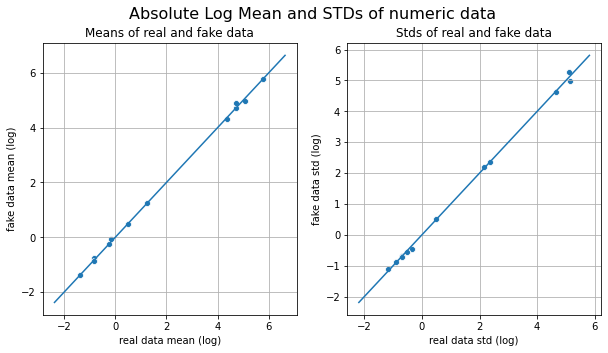

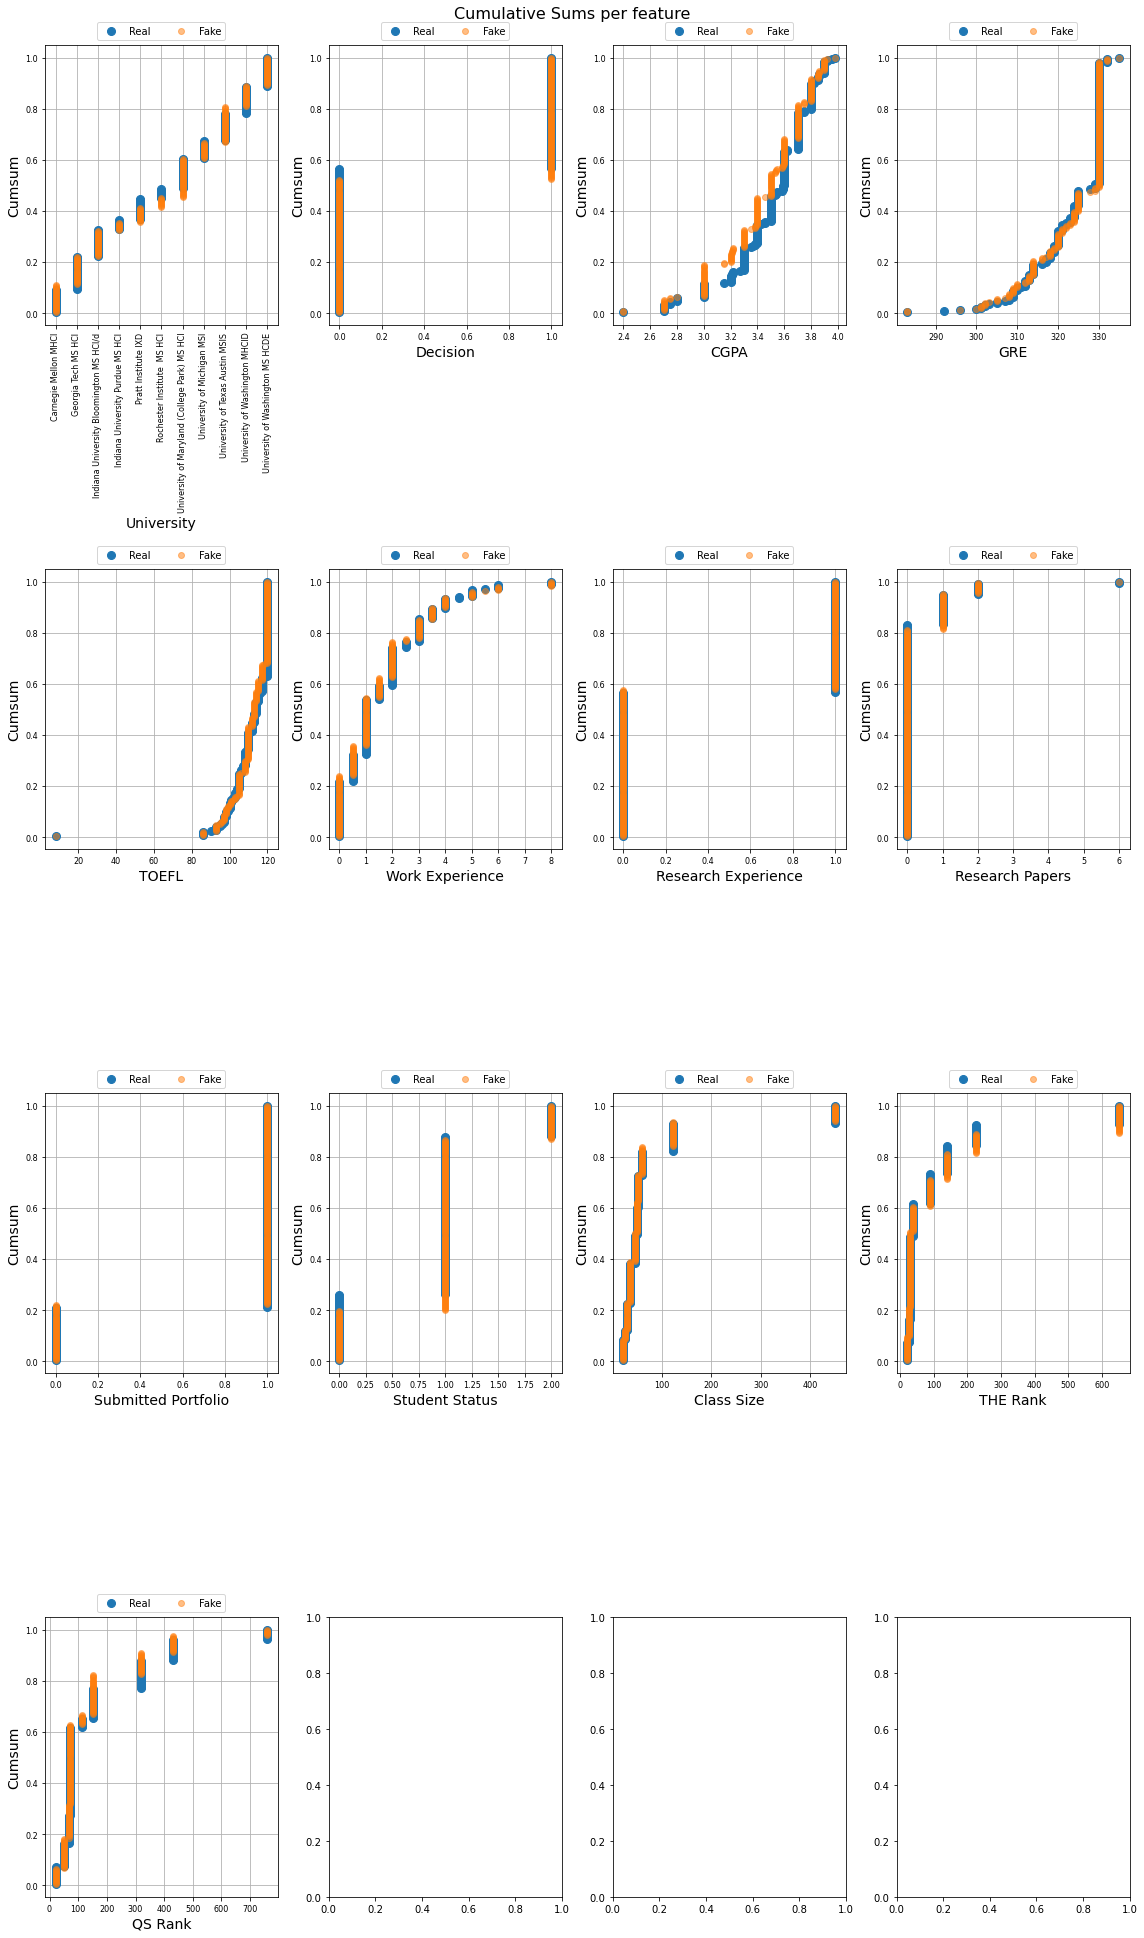

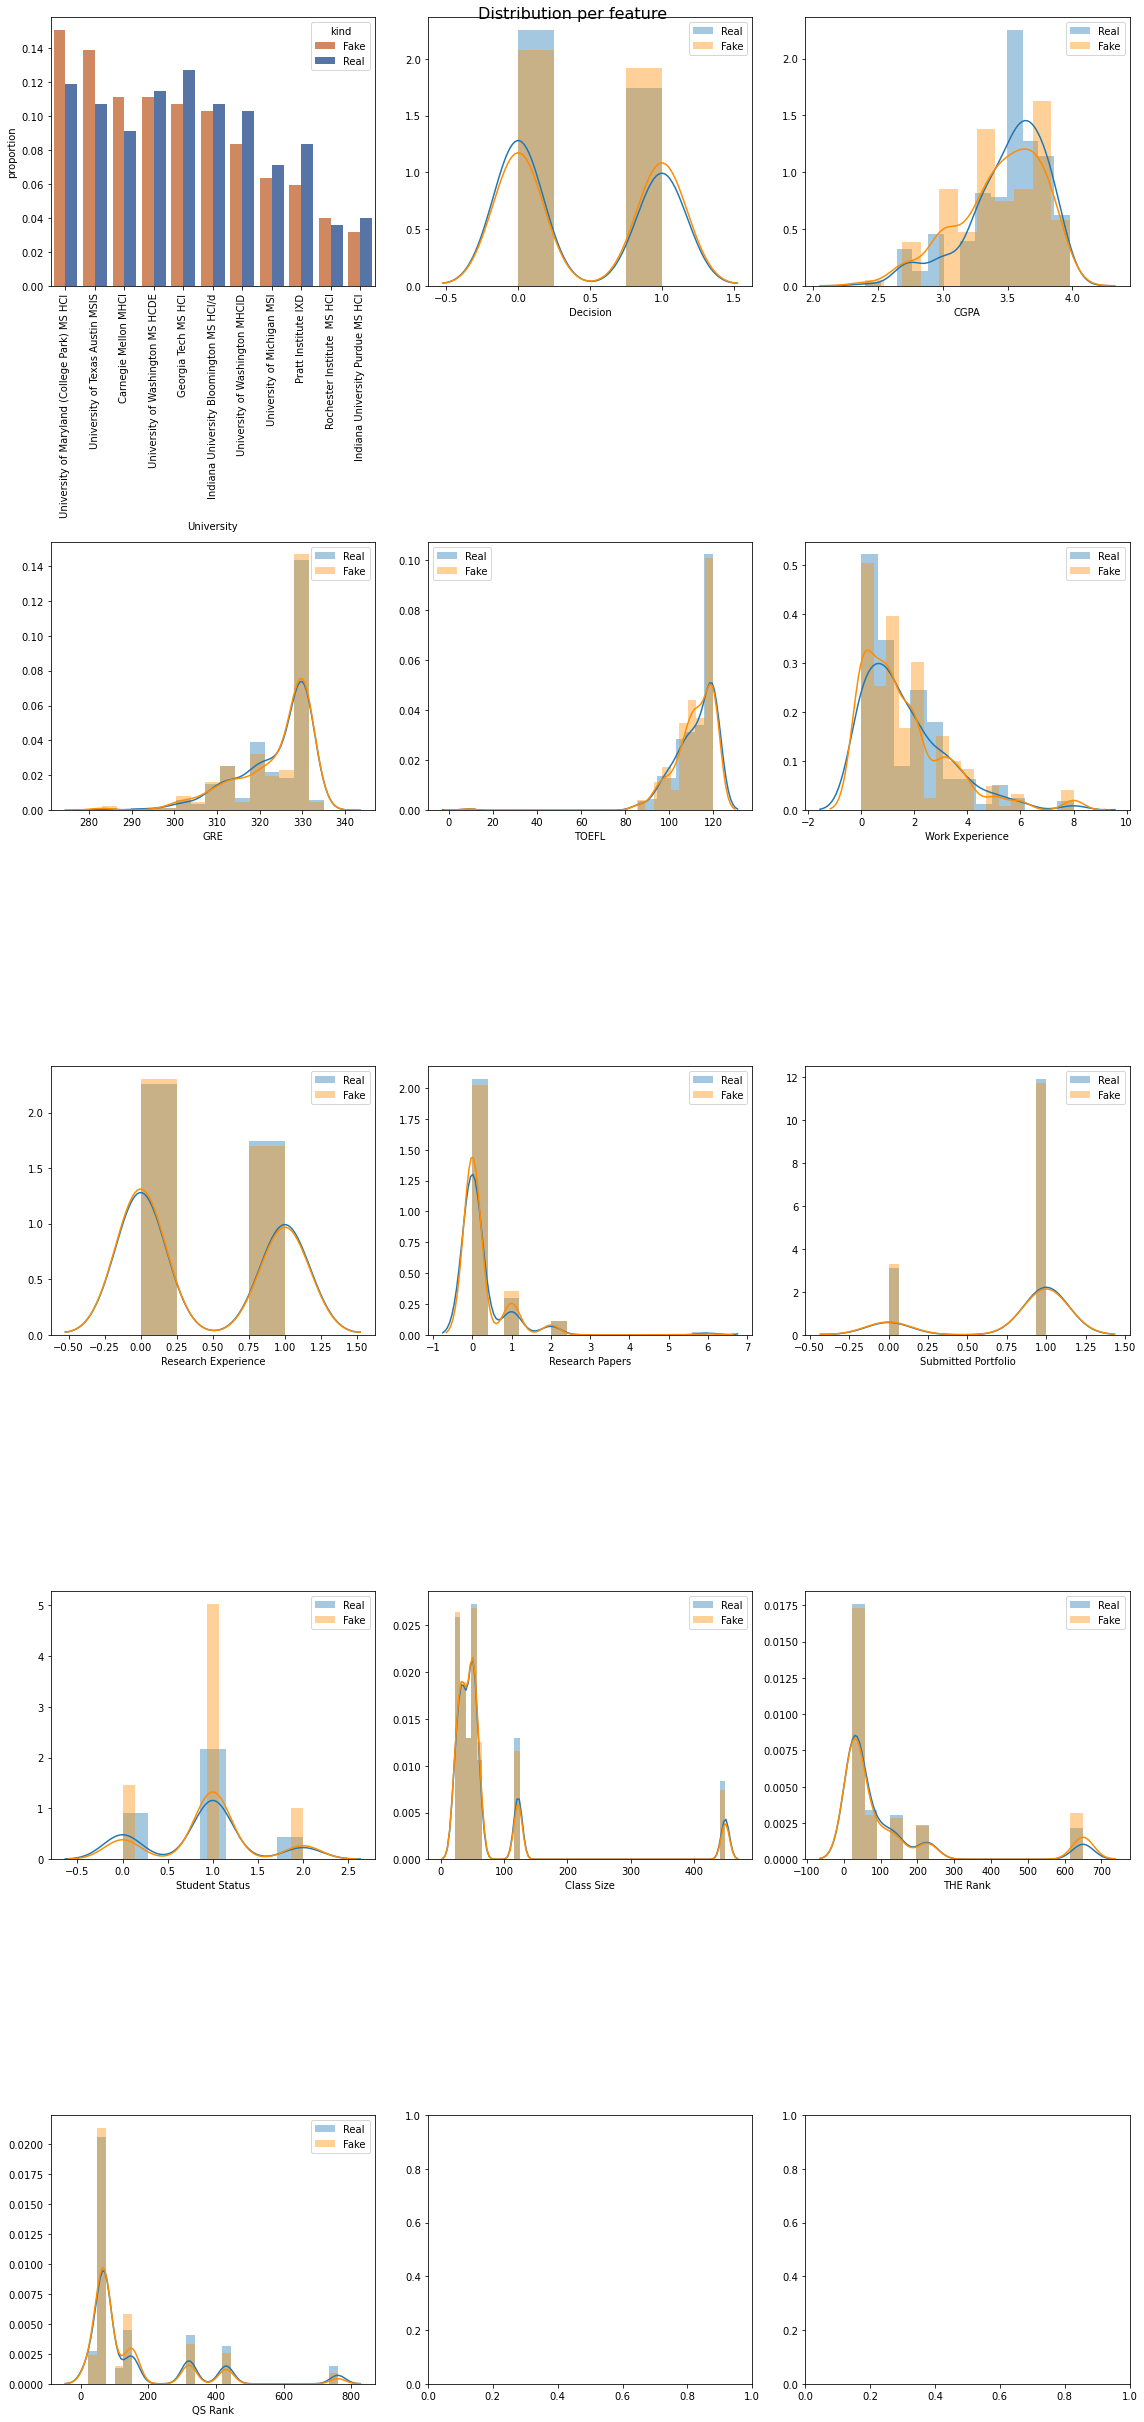

In [30]:
from table_evaluator import load_data, TableEvaluator
table_evaluator = TableEvaluator(hci_data, new_data)
try:
    table_evaluator.visual_evaluation()
except:
    print()

## Predictions for Decision
#### Done to get a better idea on what factors influence decisions the most

In [15]:
target=new_data.Decision
new_data=new_data.drop(columns=['University','Decision'])
data=new_data

#### Random Forest

In [16]:
#KCross
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)  

kf = KFold(n_splits=20, random_state=2, shuffle=True)

result = cross_val_score(rf , data, target, cv = kf)
print(result)
print()
print(result.mean())

[0.71428571 0.74603175 0.76190476 0.77777778 0.84126984 0.77777778
 0.68253968 0.76190476 0.73015873 0.76190476 0.68253968 0.80952381
 0.70967742 0.75806452 0.74193548 0.75806452 0.69354839 0.85483871
 0.90322581 0.77419355]

0.762058371735791


#### Logistic Regression

In [194]:
#Using K-Cross Validation

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=20, random_state=42, shuffle=True)
model = LogisticRegression(solver='lbfgs',max_iter=1000)
result = cross_val_score(model , data, target, cv = kf)
print(result)
print()
print(result.mean())

[0.61904762 0.57142857 0.63492063 0.50793651 0.61904762 0.57142857
 0.65079365 0.50793651 0.71428571 0.61904762 0.63492063 0.71428571
 0.59677419 0.64516129 0.67741935 0.59677419 0.58064516 0.72580645
 0.66129032 0.62903226]

0.6238991295442908


#### XGBoost

In [195]:
from xgboost import XGBClassifier
model = XGBClassifier()
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
result = cross_val_score(model, data, target, cv=kfold)
print(result)
print()
print(result.mean())

[0.76984127 0.75396825 0.768      0.72       0.816      0.808
 0.736      0.8        0.784      0.752     ]

0.7707809523809523


### Visualizing factors that contribute most towards admissions decisions

Accuracy: 76.10%


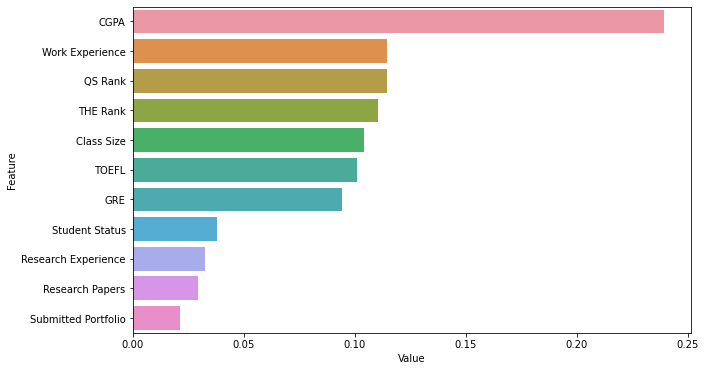

In [18]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2,random_state=10)

#Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=5)  
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test) 
accuracy=accuracy_score(y_test,y_pred,normalize=True)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

feature_importance = pd.DataFrame(sorted(zip(rf.feature_importances_, data.columns)), columns=['Value','Feature']) 
plt.figure(figsize=(10, 6)) 
sns.barplot(x="Value", y="Feature", data=feature_importance.sort_values(by="Value", ascending=False)) 

## Specific University
### The purpose of the predictor is to understand the chances of admission into a *specific* university. I'm doing this by simply extracting the desired university from the synthesized dataset and running the prediction models

### Specific University - Georgia Tech

In [316]:
gt=pd.concat([hci_data,synthetic_data_acc,synthetic_data_rej],ignore_index=True)
gt=gt.loc[gt['University'] == 'Georgia Tech MS HCI']
gt

,University,Decision,CGPA,GRE,TOEFL,Work Experience,Research Experience,Research Papers,Submitted Portfolio,Student Status,Class Size,THE Rank,QS Rank
0,Georgia Tech MS HCI,1,3.80,330.0,117.0,1.0,1,2,1,1,52,38,70
1,Georgia Tech MS HCI,1,3.50,330.0,112.0,4.0,1,6,1,1,52,38,70
2,Georgia Tech MS HCI,1,3.20,330.0,120.0,2.0,1,0,1,0,52,38,70
3,Georgia Tech MS HCI,1,2.70,320.0,113.0,1.5,0,0,1,1,52,38,70
4,Georgia Tech MS HCI,1,3.60,320.0,120.0,1.0,0,0,1,2,52,38,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1221,Georgia Tech MS HCI,1,3.20,330.0,120.0,0.5,0,0,1,1,52,38,72
1225,Georgia Tech MS HCI,1,3.85,330.0,117.0,0.5,0,0,1,1,50,29,70
1226,Georgia Tech MS HCI,1,3.00,313.0,112.0,0.0,1,0,0,0,122,28,115
1236,Georgia Tech MS HCI,1,3.80,319.0,108.0,0.5,0,0,1,2,122,28,152


In [317]:
gt=gt.drop(columns=['University'])
target=gt.Decision
gt=gt.drop(columns=['Decision'])
data=gt

#### Random Forest

In [318]:
#KCross
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=40, random_state=4)  

kf = KFold(n_splits=5, random_state=42,shuffle=True)

result = cross_val_score(rf , data, target, cv = kf)
print(result)
print()
print(result.mean())

[0.71052632 0.7027027  0.67567568 0.75675676 0.64864865]

0.6988620199146516


#### Logistic Regression

In [319]:
#Using K-Cross Validation

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, random_state=42, shuffle=True)
model = LogisticRegression(solver='lbfgs',max_iter=2000)
result = cross_val_score(model , data, target, cv = kf)
print(result)
print()
print(result.mean())

[0.57894737 0.57894737 0.73684211 0.63157895 0.57894737 0.57894737
 0.61111111 0.77777778 0.72222222 0.61111111]

0.6406432748538012


#### XGBoost

In [324]:
from xgboost import XGBClassifier
model = XGBClassifier()
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
result = cross_val_score(model, data, target, cv=kfold)
print(result)
print()
print(result.mean())

[0.68421053 0.73684211 0.84210526 0.73684211 0.73684211 0.78947368
 0.72222222 0.72222222 0.66666667 0.88888889]

0.7526315789473685


#### LGBM

In [315]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean

model = LGBMClassifier()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
n_scores = cross_val_score(model, data, target, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f' % (mean(n_scores)))

Accuracy: 0.726


### Specific University - Maryland

In [307]:
umd=pd.concat([hci_data,synthetic_data_acc,synthetic_data_rej],ignore_index=True)
umd=umd.loc[umd['University'] == 'University of Maryland (College Park) MS HCI']
umd

,University,Decision,CGPA,GRE,TOEFL,Work Experience,Research Experience,Research Papers,Submitted Portfolio,Student Status,Class Size,THE Rank,QS Rank
199,University of Maryland (College Park) MS HCI,0,2.75,320.0,113.0,1.5,0,0,1,1,35,90,152
200,University of Maryland (College Park) MS HCI,0,3.90,330.0,120.0,1.0,0,0,1,2,35,90,152
201,University of Maryland (College Park) MS HCI,0,3.30,314.0,114.0,3.5,1,0,1,1,35,90,152
202,University of Maryland (College Park) MS HCI,1,3.00,313.0,110.0,0.0,0,0,1,1,35,90,152
203,University of Maryland (College Park) MS HCI,1,3.70,313.0,117.0,1.0,0,0,1,1,35,90,152
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1224,University of Maryland (College Park) MS HCI,1,3.90,330.0,100.0,0.5,0,0,1,1,30,29,72
1230,University of Maryland (College Park) MS HCI,1,3.59,313.0,104.0,0.0,1,0,1,1,35,140,51
1231,University of Maryland (College Park) MS HCI,1,3.20,309.0,107.0,4.0,0,0,1,2,22,38,51
1240,University of Maryland (College Park) MS HCI,1,3.50,325.0,103.0,0.0,1,0,1,1,50,38,72


In [308]:
umd=umd.drop(columns=['University'])
target=umd.Decision
umd=umd.drop(columns=['Decision'])
data=umd

#### Random Forest

In [309]:
#KCross
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=60, random_state=42)  

kf = KFold(n_splits=5, random_state=42,shuffle=True)

result = cross_val_score(rf , data, target, cv = kf)
print(result)
print()
print(result.mean())

[0.72       0.84       0.84       0.72       0.58333333]

0.7406666666666667


#### Logistic Regression

In [306]:
#Using K-Cross Validation

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, random_state=42, shuffle=True)
model = LogisticRegression(solver='lbfgs',max_iter=2000)
result = cross_val_score(model , data, target, cv = kf)
print(result)
print()
print(result.mean())

[0.52       0.6        0.68       0.48       0.45833333]

0.5476666666666667


#### XGBoost

In [305]:
from xgboost import XGBClassifier
model = XGBClassifier()
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
result = cross_val_score(model, data, target, cv=kfold)
print(result)
print()
print(result.mean())

[0.84615385 0.69230769 0.84615385 0.69230769 0.75       0.83333333
 0.75       0.83333333 0.66666667 0.75      ]

0.7660256410256411


#### LGBM

In [303]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean

model = LGBMClassifier()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
n_scores = cross_val_score(model, data, target, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f' % (mean(n_scores)))

Accuracy: 0.707
